In [1]:
# Basic packages.
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
tf.config.run_functions_eagerly(True)

# Visualization packages.
import seaborn as sns
import matplotlib.pyplot as plt

# Initial Work / Transformations

### Read in the data.

It is obvious to note that there are missing values present in the data. This is mostly due to not having data reach back to the year 1919 for most features present in the FRED data pull, as demonstrated below.

In [2]:
# Necessary variables for file exploration.
DATA_DIR = 'data'
TRANSFORMED_DIR = 'transformed'
feature_file = 'transformed_features.csv'
response_file = 'transformed_responses.csv'

# Read in the data.
feature_df = pd.read_csv('{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, feature_file))
response_df = pd.read_csv('{}/{}/{}'.format(DATA_DIR, TRANSFORMED_DIR, response_file))
feature_df.shape, response_df.shape

# Convert date to str & set as index.
feature_df['DATE'] = pd.to_datetime(feature_df['DATE'])
feature_df.set_index('DATE', drop=True, inplace=True)
response_df['Date'] = pd.to_datetime(response_df['Date'])
response_df.set_index('Date', drop=True, inplace=True)

### Transform response data to binary classifications.

In [3]:
# Focus only on the final 4 --> Equity Indices, Fixed Income, and Commodities.
binary_df = pd.DataFrame(columns=["Stock", "Bonds", "Commodities"], index=response_df.index)
binary_df['Stock'] = response_df['Equity Indices Market'].apply(lambda x: 1 if x > 0 else 0)
binary_df['Bonds'] = response_df['Fixed Income Market'].apply(lambda x: 1 if x > 0 else 0)
binary_df['Commodities'] = response_df['Commodities Market'].apply(lambda x: 1 if x > 0 else 0)

In [4]:
binary_df.groupby('Stock').count()

,Bonds,Commodities
Stock,,
0,137,137
1,218,218


In [5]:
binary_df.groupby('Bonds').count()

,Stock,Commodities
Bonds,,
0,127,127
1,228,228


In [6]:
binary_df.groupby('Commodities').count()

,Stock,Bonds
Commodities,,
0,163,163
1,192,192


Slight imbalance --> we can see that there are slightly more positive return months than negative for STOCKS. The imbalance is even more prevalent in the BONDS data while the COMMODITIES data is more balanced. However, none of these imbalances are significant enough to warrant action via SMOTE or some other oversampling (or even undersampling) techinque. Therefore, use various types of Neural Networks to determine which is best for this type of data. The characteristics of this data are:
* Monthly 
* Filled w/ underlying interactions (i.e. latent variables)
* No seasonality --> because the return data is % month-to-month.

In [7]:
response_df.shape, binary_df.shape

((355, 44), (355, 3))

# CLASSIFICATION

Only going to focus on the high-level asset classes: Equity Indices Market, Fixed Income Market, and Commodities Market.

In [8]:
feature_df.index, binary_df.index

(DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
                '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
                '1992-09-01', '1992-10-01',
                ...
                '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
                '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
                '2021-06-01', '2021-07-01'],
               dtype='datetime64[ns]', name='DATE', length=355, freq=None),
 DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
                '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
                '1992-09-01', '1992-10-01',
                ...
                '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
                '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
                '2021-06-01', '2021-07-01'],
               dtype='datetime64[ns]', name='Date', length=355, freq=None))

In [9]:
# Perform a train-test split. Looking at the above data, let's train on all data prior to end of year 2005.
# Test on all data from 2005 to end of year 2019
# Keep beginning of 2020 through 2021 seperate for analysis and comparisons with other methods.
dates = np.array(feature_df.index)
# Add 1 to include December as a part of the train.
training_ends = np.where(dates == pd.to_datetime("2009-12-01"))[0][0] + 1
test_ends = np.where(dates == pd.to_datetime("2019-12-01"))[0][0] + 1
X_train, X_test, X_analysis = feature_df.iloc[:training_ends, :], feature_df.iloc[training_ends:test_ends, :], feature_df.iloc[test_ends:, :]
y_train, y_test, y_analysis = binary_df.iloc[:training_ends, :], binary_df.iloc[training_ends:test_ends, :], binary_df.iloc[test_ends:, :]
X_train.shape, X_test.shape, X_analysis.shape

((216, 58), (120, 58), (19, 58))

In [10]:
type(X_train), type(y_train), type(X_test), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

## Simple Neural Networks

In [11]:
# Create a simple Neural Network with two or three layers. Expectation is not great performance
# However, iterative model development is always best. This simple neural network will have input-output
# layer.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=X_train.shape[1], input_dim=X_train.shape[1], activation='relu', name="input-layer"))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name="output-layer"))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.Accuracy())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input-layer (Dense)          (None, 58)                3422      
_________________________________________________________________
output-layer (Dense)         (None, 1)                 59        
Total params: 3,481
Trainable params: 3,481
Non-trainable params: 0
_________________________________________________________________


2021-09-05 20:46:41.162512: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Fit the model on the first column of y_train because we are focused on Equities data.
col_num = 0
history = model.fit(X_train.values, y_train.values[:, col_num], batch_size=6, epochs=100, validation_data=(X_test.values, y_test.values[:, col_num]), shuffle=False)

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2021-09-05 20:46:41.292706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
36/36 [==============================] - 1s 10ms/step - loss: 16389.6836 - accuracy: 0.4630 - val_loss: 8372.8311 - val_accuracy: 0.5083
Epoch 2/100
36/36 [==============================] - 0s 9ms/step - loss: 16890.9473 - accuracy: 0.5139 - val_loss: 20860.8828 - val_accuracy: 0.3583
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 18691.1699 - accuracy: 0.4907 - val_loss: 17765.4746 - val_accuracy: 0.3583
Epoch 4/100
36/36 [==============================] - 0s 12ms/step - loss: 12292.5938 - accuracy: 0.4259 - val_loss: 5307.0200 - val_accuracy: 0.5000
Epoch 5/100
36/36 [==============================] - 0s 12ms/step - loss: 5782.7744 - accuracy: 0.4815 - val_loss: 3792.4521 - val_accuracy: 0.5000
Epoch 6/100
36/36 [==============================] - 0s 11ms/step - loss: 7316.0786 - accuracy: 0.4028 - val_loss: 4224.7051 - val_accuracy: 0.6417
Epoch 7/100
36/36 [==============================] - 0s 12ms/step - loss: 1855.9568 - accuracy: 0.4769 - val

In [13]:
def graphHistory(history, title):
    """
    Function for graphing the training and valiedation accuracy and loss
    ...
    :param history - history object from keras desired to plot.
    :param title - str that will be the title of the resulting plot.
    """
    # summarize history for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    #axes[0].title('Model Accuracy ' + title)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Tr. Acc', 'Val. Acc'])

    # summarize history for loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    #axes[1].title('Model Loss ' + title)
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Tr. Loss', 'Val. Loss'])
    plt.title(title)
    plt.tight_layout()
    plt.show()

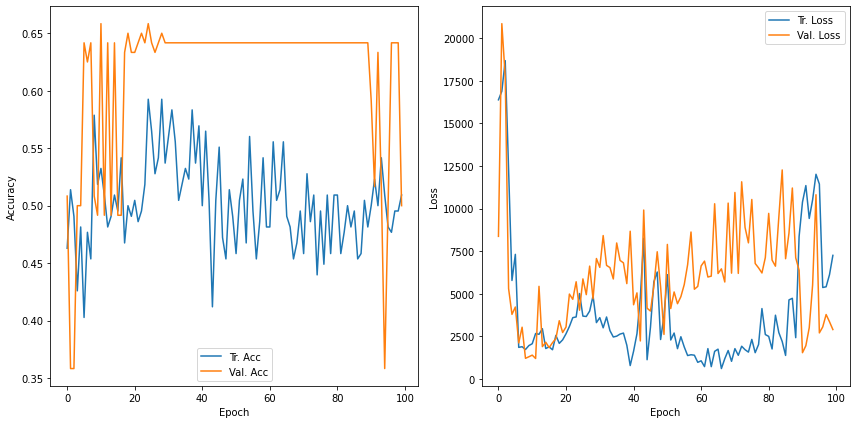

In [14]:
graphHistory(history, "Simple Neural Network")

As the above plot shows, the simple neural network seriously struggles with learning the training data in terms of classifying when the overall Equities Market is going up or down. Therefore, more sophisticated models are needed to learn the above interactions. There are two possible saviors...
1. Deep Neural Networks -- add many more layers and/or neurons to attempt to learn the non-linearities of the market data.
2. Recurrent Neural Networks -- utilize past data of returns to predict the direction of future returns (i.e. the neural network version of a ARMA model).

## Deep Neural Networks

Leveraging the work found [here](https://towardsdatascience.com/how-to-use-convolutional-neural-networks-for-time-series-classification-56b1b0a07a57).

Imagine a time series with of length n and width k, where the length is the number of timesteps and width is the number of variables in the multi-variate time series. Therefore, in this data, we have a length of 355 total (lower when the train test split is done) and a width of 58. 

The convolution kernels always have the same width as the time-series (58 in this instance). 

Then, apply the global max pooling to each of the filtered time series vector where the largest value is taken frome each vector. This forms a new vector (of maximums) that is then connected to a full dense layer. 

**TO DO THIS**, need to transform data from ``(# of time steps, # of features)`` to ``(# of samples, # of time steps, # of features)``.

In [15]:
##################
# UNIVARIATE CNN #
##################
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)



In [16]:
X_train, y_train = split_sequence(y_train.values[:, 0], 12)
X_test, y_test = split_sequence(y_test.values[:, 0], 12)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((204, 12), (204,), (108, 12), (108,))

In [18]:
# Reshape from (samples, timesteps) to (samples, timesteps, features)
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], 1, n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], 1, n_features))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((204, 12, 1), (204, 1, 1), (108, 12, 1), (108, 1, 1))

In [19]:
# CNN Model
cnn_simple = tf.keras.models.Sequential(name="Simple CNN")
cnn_simple.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(12, 1)))
cnn_simple.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_simple.add(tf.keras.layers.Flatten())
cnn_simple.add(tf.keras.layers.Dense(50, activation='relu'))
cnn_simple.add(tf.keras.layers.Dense(1))
cnn_simple.compile(optimizer='adam', loss='mse', metrics='accuracy')
cnn_simple.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 11, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                16050     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
_________________________________________________________________


In [21]:
# history = model.fit(X_train.values, y_train.values[:, col_num], batch_size=6, epochs=100, validation_data=(X_test.values, y_test.values[:, col_num]), shuffle=False)
history = cnn_simple.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 0.4800 - accuracy: 0.4069 - val_loss: 0.2359 - val_accuracy: 0.6574
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 0.2892 - accuracy: 0.4062

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 14ms/step - loss: 0.2829 - accuracy: 0.5245 - val_loss: 0.2583 - val_accuracy: 0.6667
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2757 - accuracy: 0.5735 - val_loss: 0.2356 - val_accuracy: 0.6389
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2536 - accuracy: 0.5686 - val_loss: 0.2470 - val_accuracy: 0.5370
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2535 - accuracy: 0.5392 - val_loss: 0.2411 - val_accuracy: 0.5741
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2476 - accuracy: 0.5833 - val_loss: 0.2341 - val_accuracy: 0.6204
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2451 - accuracy: 0.6029 - val_loss: 0.2333 - val_accuracy: 0.6204
Epoch 8/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2416 - accuracy: 0.6176 - val_loss: 0.2341 - val_accuracy: 0.5741
Epoch 9/100
7/7 [===============

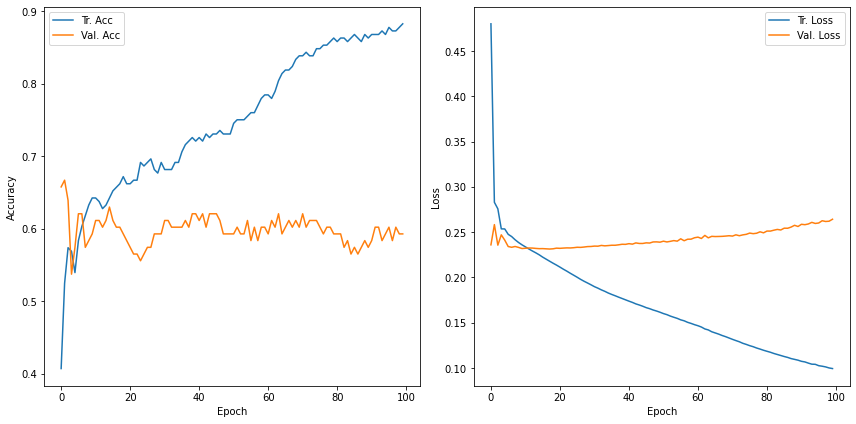

In [22]:
graphHistory(history, "CNN")

The above graph definitnely implies some overfitting. This is extremely prevalent epoch 20 and beyond as our training accuracy continues to increase while our validation accuracy stays flat, and some could say decreases slightly. Therefore, we need to address some overfitting issues / find ways to increase performance.

1. Regualarization
2. Weight Initialization
3. Dropout Regularization

In [25]:
# Start with easiest, weight initilazaiton.
# CNN Model
cnn_simple = tf.keras.models.Sequential(name="CNN w/ weight initialization")
cnn_simple.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, kernel_initializer='he_normal', activation='relu', input_shape=(12, 1)))
cnn_simple.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_simple.add(tf.keras.layers.Flatten())
cnn_simple.add(tf.keras.layers.Dense(50, kernel_initializer='he_normal', activation='relu'))
cnn_simple.add(tf.keras.layers.Dense(1, kernel_initializer='he_normal'))
cnn_simple.compile(optimizer='adam', loss='mse', metrics='accuracy')
cnn_simple.summary()

Model: "CNN w/ weight initialization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 11, 64)            192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - 0s 18ms/step - loss: 1.3637 - accuracy: 0.4608 - val_loss: 0.6592 - val_accuracy: 0.6019
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 0.8043 - accuracy: 0.4375

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 15ms/step - loss: 0.5425 - accuracy: 0.4951 - val_loss: 0.5566 - val_accuracy: 0.3611
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 0.3804 - accuracy: 0.5000 - val_loss: 0.4164 - val_accuracy: 0.6667
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.3558 - accuracy: 0.5343 - val_loss: 0.3453 - val_accuracy: 0.3981
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2938 - accuracy: 0.5343 - val_loss: 0.2809 - val_accuracy: 0.5833
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2654 - accuracy: 0.6078 - val_loss: 0.2713 - val_accuracy: 0.5648
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2428 - accuracy: 0.5343 - val_loss: 0.2729 - val_accuracy: 0.5926
Epoch 8/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2335 - accuracy: 0.5931 - val_loss: 0.2546 - val_accuracy: 0.5833
Epoch 9/100
7/7 [===============

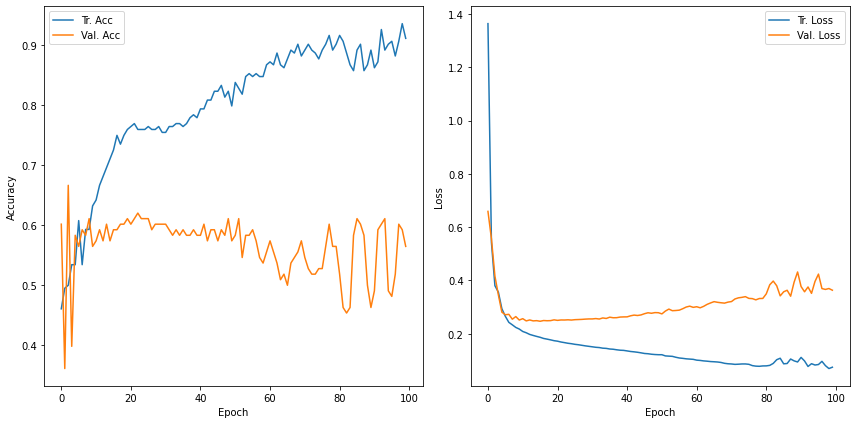

In [26]:
history = cnn_simple.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), shuffle=False)
graphHistory(history, "CNN w/ Weights")

In [27]:
# Try Regularizaiton.
cnn_simple = tf.keras.models.Sequential(name="CNN w/ Regularization")
cnn_simple.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, kernel_initializer='he_normal', activation='relu', input_shape=(12, 1), kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
cnn_simple.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_simple.add(tf.keras.layers.Flatten())
cnn_simple.add(tf.keras.layers.Dense(50, kernel_initializer='he_normal', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
cnn_simple.add(tf.keras.layers.Dense(1, kernel_initializer='he_normal'))
cnn_simple.compile(optimizer='adam', loss='mse', metrics='accuracy')
cnn_simple.summary()

Model: "CNN w/ weight initialization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 11, 64)            192       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                16050     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
7/7 [==============================] - 0s 21ms/step - loss: 2.8314 - accuracy: 0.5049 - val_loss: 2.5912 - val_accuracy: 0.5463
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 2.5271 - accuracy: 0.6562

/Users/davidmottice/Documents/AFIT/principal-try-2/project-env/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7/7 [==============================] - 0s 18ms/step - loss: 2.6025 - accuracy: 0.6176 - val_loss: 2.7061 - val_accuracy: 0.4444
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 2.5259 - accuracy: 0.5735 - val_loss: 2.4866 - val_accuracy: 0.6481
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 2.3851 - accuracy: 0.6618 - val_loss: 2.4695 - val_accuracy: 0.4722
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 2.3352 - accuracy: 0.6422 - val_loss: 2.3078 - val_accuracy: 0.6204
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 2.2411 - accuracy: 0.6961 - val_loss: 2.2855 - val_accuracy: 0.5463
Epoch 7/100
7/7 [==============================] - 0s 15ms/step - loss: 2.1936 - accuracy: 0.6618 - val_loss: 2.2086 - val_accuracy: 0.5741
Epoch 8/100
7/7 [==============================] - 0s 15ms/step - loss: 2.1323 - accuracy: 0.7157 - val_loss: 2.1679 - val_accuracy: 0.5833
Epoch 9/100
7/7 [===============

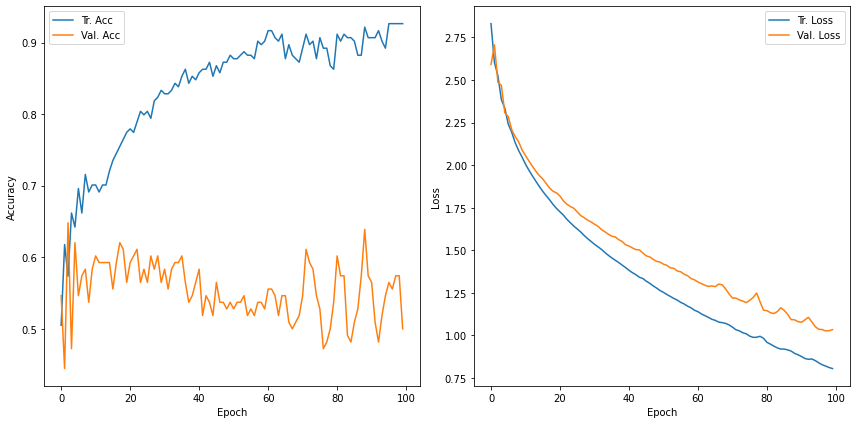

In [28]:
history = cnn_simple.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), shuffle=False)
graphHistory(history, "CNN w/ Weights")